In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import mediapipe as mp


Data preprocessing

In [2]:
dataset_path = './ISLDATASET2'
image_size = (128, 128)
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

In [3]:
def extract_landmarks(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    result = hands.process(img_rgb)

    if result.multi_hand_landmarks:
        landmarks = []
        for hand_landmarks in result.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])  # Extract x, y, z coordinates
        
        # Pad with zeros if only one hand is detected
        if len(result.multi_hand_landmarks) == 1:
            landmarks.extend([0.0] * 63)  # Pad to make it two hands (since we're working with ISL)

        return np.array(landmarks)
    else:
        return None


In [4]:
data = []
labels = []
phrases_labels = {
    "afraid": 36,
    "agree": 37,
    "assistance": 38,
    "bad": 39,
    "doctor": 40,
    "pain": 41,
    "pray": 42,
    "stand": 43,
    "work": 44,
    "you": 45
}
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if category.isdigit():
        label = int(category) + 26  # Numbers 0-9 -> 26-35

    # Handle alphabets (A-Z)
    elif len(category) == 1 and category.isalpha():
        label = ord(category.upper()) - 65  # Alphabets A-Z -> 0-25
    else:
        label = phrases_labels[category.lower()]  # Phrases -> 37-46
    print(f"Processing folder: {category} | Label: {label}")  
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        landmarks = extract_landmarks(img_path)
        if landmarks is not None:
            data.append(landmarks)
            labels.append(label)

data = np.array(data)
labels = np.array(labels)
np.save('landmark_data2.npy', data)
np.save('landmark_labels2.npy', labels)
print("Landmark extraction complete!")


Processing folder: 0 | Label: 26
Processing folder: 1 | Label: 27
Processing folder: 2 | Label: 28
Processing folder: 3 | Label: 29
Processing folder: 4 | Label: 30
Processing folder: 5 | Label: 31
Processing folder: 6 | Label: 32
Processing folder: 7 | Label: 33
Processing folder: 8 | Label: 34
Processing folder: 9 | Label: 35
Processing folder: A | Label: 0
Processing folder: afraid | Label: 36
Processing folder: agree | Label: 37
Processing folder: assistance | Label: 38
Processing folder: B | Label: 1
Processing folder: bad | Label: 39
Processing folder: C | Label: 2
Processing folder: D | Label: 3
Processing folder: doctor | Label: 40
Processing folder: E | Label: 4
Processing folder: F | Label: 5
Processing folder: G | Label: 6
Processing folder: H | Label: 7
Processing folder: I | Label: 8
Processing folder: J | Label: 9
Processing folder: K | Label: 10
Processing folder: L | Label: 11
Processing folder: M | Label: 12
Processing folder: N | Label: 13
Processing folder: O | Label

In [5]:
num_classes = 46  # A-Z (26) + 0-9 (10) + phrases(10)

model = models.Sequential([
    layers.Input(shape=(126,)),  # Input shape is now 126 (21 landmarks * 3 coordinates * 2 hands)
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)), #Fully connected layer with 128 neurons and ReLU activation.
    layers.Dropout(0.4), 
    layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,190 (86.68 KB)

 Trainable params: 22,190 (86.68 KB)

 Non-trainable params: 0 (0.00 B)

Building the model 

In [6]:
#Load the landmark data
X = np.load('landmark_data2.npy')
y = np.load('landmark_labels2.npy')

#Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))



Epoch 1/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1521 - loss: 3.3922 - val_accuracy: 0.5702 - val_loss: 2.0663
Epoch 2/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4756 - loss: 2.0503 - val_accuracy: 0.6967 - val_loss: 1.5198
Epoch 3/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6060 - loss: 1.6216 - val_accuracy: 0.7586 - val_loss: 1.2778
Epoch 4/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6639 - loss: 1.3995 - val_accuracy: 0.7772 - val_loss: 1.1475
Epoch 5/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6994 - loss: 1.2954 - val_accuracy: 0.7900 - val_loss: 1.0681
Epoch 6/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7257 - loss: 1.2089 - val_accuracy: 0.7998 - val_loss: 1.0144
Epoch 7/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7413 - loss: 1.1405 - val_accuracy: 0.8333 - val_loss: 0.9377
Epoch 8/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7573 - loss: 1.0761 - val_accuracy: 0.

In [7]:
model.save('landmark_model2.keras')
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8784 - loss: 0.6405
Test Accuracy: 87.52%


In [8]:
#Initializing MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

class_names = (
    [chr(i) for i in range(65, 91)] +  # A-Z
    [str(i) for i in range(0, 10)] +   # 0-9
    ["afraid", "agree", "assistance", "bad", "doctor", "pain", "pray", "stand", "work", "you"]  # Phrases
)


In [9]:
cap = cv2.VideoCapture(0)
languages = ['hi', 'ta', 'mr', 'gu', 'pa']  # Hindi, Tamil, Marathi, Gujarati, Punjabi
translation_cache = {}
# Variable to track the last predicted gesture
last_prediction = None
while True:
    ret, frame = cap.read()
    if not ret:
        break
    #Flip the frame for a more intuitive mirror-like view
    frame = cv2.flip(frame, 1) #horizontal flipping (mirror-like effect).
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #Process the image and extract landmarks
    result = hands.process(img_rgb)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            #Drawing landmarks and connections on the frame
            mp_draw.draw_landmarks(
                frame, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2),
                mp_draw.DrawingSpec(color=(0, 255, 0), thickness=2)
            )

            #Get bounding box coordinates
            h, w, _ = frame.shape
            x_min = int(min([lm.x for lm in hand_landmarks.landmark]) * w)# minimum x-coordinate (leftmost point of the hand).
            y_min = int(min([lm.y for lm in hand_landmarks.landmark]) * h) # maximum x-coordinate (rightmost point of the hand).
            x_max = int(max([lm.x for lm in hand_landmarks.landmark]) * w)#topmost point
            y_max = int(max([lm.y for lm in hand_landmarks.landmark]) * h)# bottom most points of the hand

            #Draw bounding box around the hand
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

            #Extracting coordinates from hand landmarks and flattens them into a 1D array.
            hand_landmarks_array = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
            if len(hand_landmarks_array) < 126:
                hand_landmarks_array = np.pad(hand_landmarks_array, (0, 126 - len(hand_landmarks_array)), mode='constant')
            hand_landmarks_array = hand_landmarks_array.reshape(1, -1)

            prediction = model.predict(hand_landmarks_array)
            predicted_label = np.argmax(prediction)  # Get the class index with highest probability
            predicted_class = class_names[predicted_label] #maps the index to the corresponding gesture label

            cv2.putText(frame, f'Prediction: {predicted_class}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            #Only translate and print if the prediction has changed
            if predicted_class != last_prediction:
                last_prediction = predicted_class

                # Check if translation is already cached
                if predicted_class not in translation_cache:
                    translations = {}
                    for lang in languages:
                        translated_text = GoogleTranslator(source='en', target=lang).translate(predicted_class)
                        translations[lang] = translated_text
                    translation_cache[predicted_class] = translations
                else:
                    translations = translation_cache[predicted_class]

                # Printing translations in output cell
                print(f"\nPrediction: {predicted_class}")
                for lang, text in translations.items():
                    print(f"{lang}: {text}")

                #displaying translations on the opencv frame
                y_offset = 100
                for lang, text in translations.items():
                    cv2.putText(frame, f'{lang}: {text}', (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2, cv2.LINE_AA)
                    y_offset += 30

    cv2.imshow("Gesture Recognition with Translation", frame)

    # Break the loop if the ESC key is pressed
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Prediction: P
hi: पी
ta: ப
mr: पी
gu: પીપ
pa: ਪੀ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Prediction: you
hi: आप
ta: நீங்கள்
mr: आपण
gu: તું
pa: ਤੁਸੀਂ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Prediction: Y
hi: Y
ta: Y
mr: वाय
gu: અઘરી
pa: ਵਾਈ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Prediction: F
hi: एफ
ta: F
mr: एफ
gu: એફ
pa: F
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Prediction: G
hi: जी
ta: G
mr: जी
gu: સજાગ
pa: ਜੀ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Prediction: U
hi: यू
ta: யு
mr: यू
gu: યુ
pa: ਯੂ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Prediction: D
hi: डी
ta: D
mr: डी
gu: કદરૂપું
pa: ਡੀ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


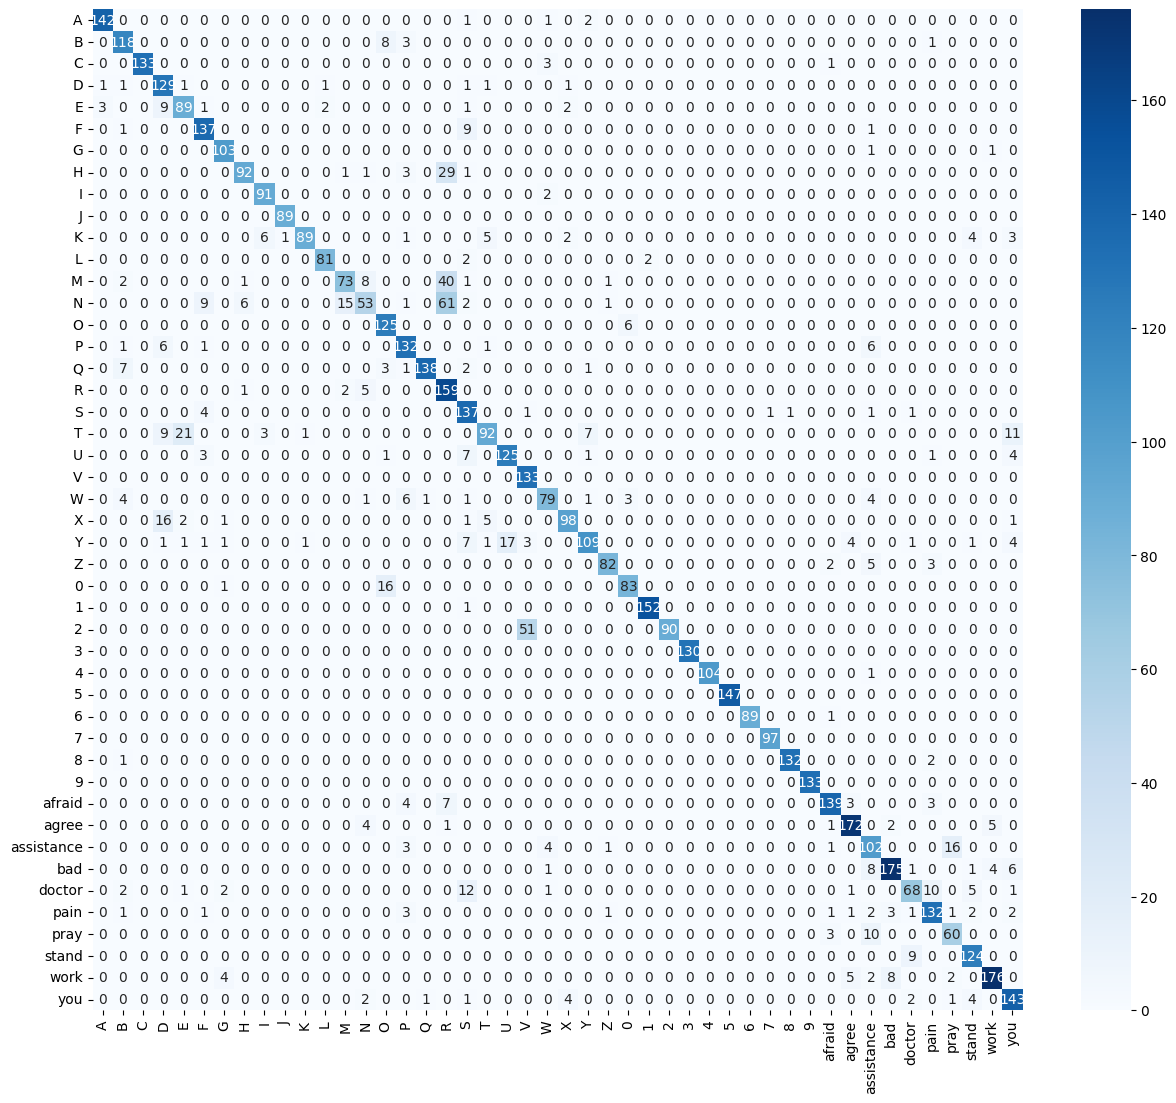

In [10]:

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(15, 13))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)


plt.show()


In [11]:
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 87.52%
Precision: 0.89
Recall: 0.88
F1 Score: 0.87


In [12]:

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  

accuracy = accuracy_score(y_test, y_pred_classes)

# Calculate precision, recall, and F1 score for each class
precision_per_class = precision_score(y_test, y_pred_classes, average=None)
recall_per_class = recall_score(y_test, y_pred_classes, average=None)
f1_per_class = f1_score(y_test, y_pred_classes, average=None)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nPrecision, Recall, and F1 Score for each class:")
for idx, class_name in enumerate(class_names):
    print(f"Class {class_name}: Precision={precision_per_class[idx]:.2f}, Recall={recall_per_class[idx]:.2f}, F1 Score={f1_per_class[idx]:.2f}")


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
Accuracy: 87.52%

Precision, Recall, and F1 Score for each class:
Class A: Precision=0.97, Recall=0.97, F1 Score=0.97
Class B: Precision=0.86, Recall=0.91, F1 Score=0.88
Class C: Precision=1.00, Recall=0.97, F1 Score=0.99
Class D: Precision=0.76, Recall=0.95, F1 Score=0.84
Class E: Precision=0.77, Recall=0.83, F1 Score=0.80
Class F: Precision=0.87, Recall=0.93, F1 Score=0.90
Class G: Precision=0.92, Recall=0.98, F1 Score=0.95
Class H: Precision=0.92, Recall=0.72, F1 Score=0.81
Class I: Precision=0.91, Recall=0.98, F1 Score=0.94
Class J: Precision=0.99, Recall=1.00, F1 Score=0.99
Class K: Precision=0.98, Recall=0.80, F1 Score=0.88
Class L: Precision=0.96, Recall=0.95, F1 Score=0.96
Class M: Precision=0.80, Recall=0.58, F1 Score=0.67
Class N: Precision=0.72, Recall=0.36, F1 Score=0.48
Class O: Precision=0.82, Recall=0.95, F1 Score=0.88
Class P: Precision=0.84, Recall=0.90, F1 Score=0.87
Class Q: Precision=0.99, Recall=0.91, F1 Score=0.95
Class R

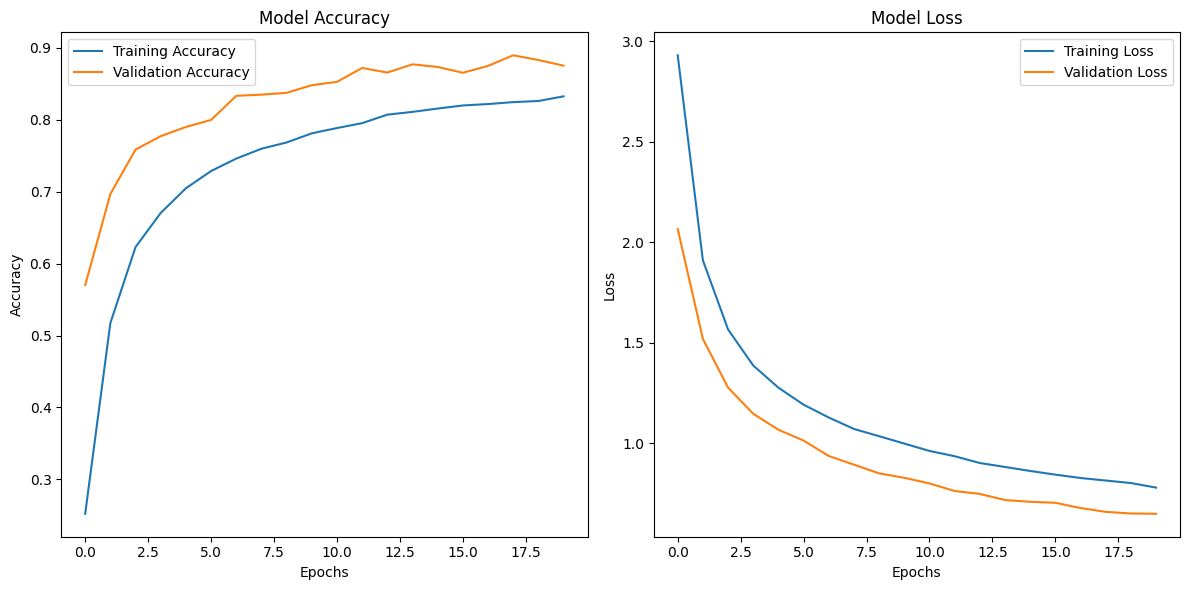

In [13]:

plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
